Matrix X

<>:168: SyntaxWarning: invalid escape sequence '\c'
<>:170: SyntaxWarning: invalid escape sequence '\c'
<>:168: SyntaxWarning: invalid escape sequence '\c'
<>:170: SyntaxWarning: invalid escape sequence '\c'
C:\Users\pleal\AppData\Local\Temp\ipykernel_20456\1764349841.py:168: SyntaxWarning: invalid escape sequence '\c'
  label=f'$\chi^2_{{1, 0.95}}={chi2_p95_df1:.2f}$')
C:\Users\pleal\AppData\Local\Temp\ipykernel_20456\1764349841.py:170: SyntaxWarning: invalid escape sequence '\c'
  label=f'$\chi^2_{{1, 0.975}}={chi2_p975_df1:.2f}$')



--- FASE I: Establecimiento de Parámetros ---
Limpieza finalizada en iteración 3.
Índices originales eliminados: [np.int64(18), 24]
Tamaño final Y_clean: (28, 3)
Umbral Fase II (P97.5): 8.2135

--- FASE II: Monitoreo de Nuevos Datos ---

Resultados Fase II y Análisis de Contribución para Outliers:
Espécimen 31: D² = 4.2148 - BAJO CONTROL
Espécimen 32: D² = 0.3227 - BAJO CONTROL
Espécimen 33: D² = 3.7368 - BAJO CONTROL
Espécimen 34: D² = 4.5971 - BAJO CONTROL
Espécimen 35: D² = 2.5371 - BAJO CONTROL
Espécimen 36: D² = 1.8862 - BAJO CONTROL
Espécimen 37: D² = 3.0788 - BAJO CONTROL
Espécimen 38: D² = 4.2000 - BAJO CONTROL
Espécimen 39: D² = 7.5474 - BAJO CONTROL
Espécimen 40: D² = 3.6875 - BAJO CONTROL
Espécimen 41: D² = 8.8860 - FUERA DE CONTROL
  Principal contribuyente: 'Density' (contribución: 4.6142)


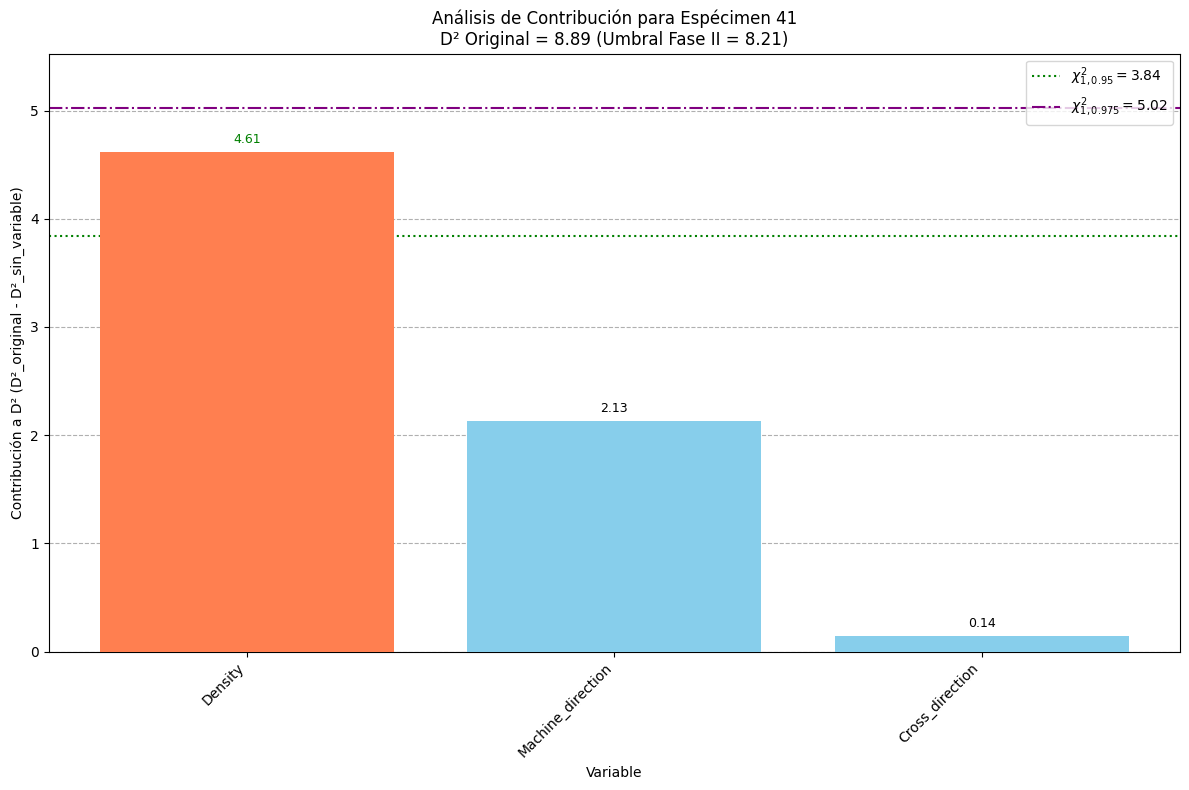

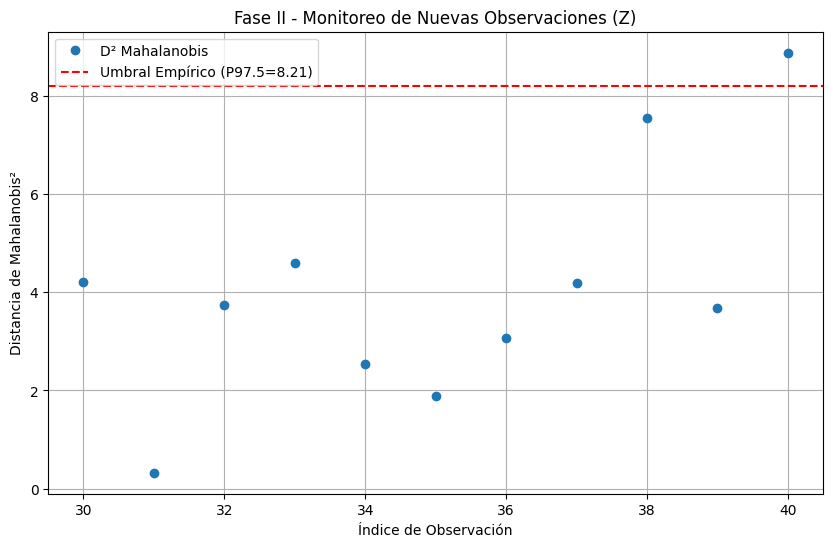


Número de observaciones fuera de control en Fase II: 1

Análisis completado.


In [6]:
import pandas as pd
from io import StringIO
import numpy as np
from scipy.spatial import distance
from scipy.stats import chi2 # Importante para los cuantiles
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# --- Carga de Datos ---
data_str = """
Specimen Density Machine_direction Cross_direction
1 .801 121.41 70.42
2 .824 127.70 72.47
3 .841 129.20 78.20
4 .816 131.80 74.89
5 .840 135.10 71.21
6 .842 131.50 78.39
7 .820 126.70 69.02
8 .802 115.10 73.10
9 .828 130.80 79.28
10 .819 124.60 76.48
11 .826 118.31 70.25
12 .802 114.20 72.88
13 .810 120.30 68.23
14 .802 115.70 68.12
15 .832 117.51 71.62
16 .796 109.81 53.10
17 .759 109.10 50.85
18 .770 115.10 51.68
19 .759 118.31 50.60
20 .772 112.60 53.51
21 .806 116.20 56.53
22 .803 118.00 70.70
23 .845 131.00 74.35
24 .822 125.70 68.29
25 .971 126.10 72.10
26 .816 125.80 70.64
27 .836 125.50 76.33
28 .815 127.80 76.75
29 .822 130.50 80.33
30 .822 127.90 75.68
31 .843 123.90 78.54
32 .824 124.10 71.91
33 .788 120.80 68.22
34 .782 107.40 54.42
35 .795 120.70 70.41
36 .805 121.91 73.68
37 .836 122.31 74.93
38 .788 110.60 53.52
39 .772 103.51 48.93
40 .776 110.71 53.67
41 .758 113.80 52.42
"""

df_total = pd.read_csv(StringIO(data_str), sep=" ")
features = ["Density", "Machine_direction", "Cross_direction"]

# --- Funciones Auxiliares (sin cambios, solo se omiten para brevedad en la respuesta) ---
def calculate_mahalanobis_squared(data_df, mean_vec=None, inv_cov_matrix=None):
    if not isinstance(data_df, pd.DataFrame) or data_df.empty:
        return np.array([])
    data_values = data_df.values
    if data_values.shape[1] == 0:
        return np.array([])

    if mean_vec is None:
        if data_values.shape[0] <= data_values.shape[1]:
            return np.full(data_values.shape[0], np.nan)
        mean_vec = np.mean(data_values, axis=0)
    if inv_cov_matrix is None:
        if data_values.shape[0] <= data_values.shape[1]:
            return np.full(data_values.shape[0], np.nan)
        cov_matrix = np.cov(data_values.T)
        if np.linalg.cond(cov_matrix) < 1/np.finfo(cov_matrix.dtype).eps:
            inv_cov_matrix = np.linalg.inv(cov_matrix)
        else:
            inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    if data_values.shape[1] != mean_vec.shape[0] or \
       mean_vec.shape[0] != inv_cov_matrix.shape[0] or \
       inv_cov_matrix.shape[0] != inv_cov_matrix.shape[1]:
        return np.full(data_values.shape[0], np.nan)

    diffs = data_values - mean_vec
    if diffs.ndim == 1:
        diffs = diffs.reshape(-1, 1)
    if inv_cov_matrix.ndim == 0: # escalar
        d_squared = (diffs**2) * inv_cov_matrix
        return d_squared.flatten()
    elif inv_cov_matrix.shape == (1,1):
        d_squared = (diffs @ inv_cov_matrix @ diffs.T).diagonal()
        return d_squared
    else:
        d_squared = np.diag(diffs @ inv_cov_matrix @ diffs.T)
        return d_squared

def get_empirical_threshold_and_distribution(data_df, n_resamples=1000, percentile=95):
    if not isinstance(data_df, pd.DataFrame) or data_df.empty:
        return np.inf, []
    num_obs, num_vars = data_df.shape
    if num_obs <= num_vars:
        return np.inf, []
    all_bootstrap_d_squared = []
    data_values = data_df.values
    for _ in range(n_resamples):
        indices = np.random.choice(num_obs, size=num_obs, replace=True)
        bootstrap_sample = data_values[indices, :]
        if bootstrap_sample.shape[0] <= bootstrap_sample.shape[1] or len(np.unique(indices)) <= bootstrap_sample.shape[1]:
            continue
        mean_boot = np.mean(bootstrap_sample, axis=0)
        cov_boot = np.cov(bootstrap_sample.T)
        if np.linalg.cond(cov_boot) < 1/np.finfo(cov_boot.dtype).eps:
            inv_cov_boot = np.linalg.inv(cov_boot)
        else:
            inv_cov_boot = np.linalg.pinv(cov_boot)
        diffs_boot = bootstrap_sample - mean_boot
        d_squared_boot = np.diag(diffs_boot @ inv_cov_boot @ diffs_boot.T)
        all_bootstrap_d_squared.extend(d_squared_boot)
    if not all_bootstrap_d_squared:
        return np.inf, []
    return np.percentile(all_bootstrap_d_squared, percentile), all_bootstrap_d_squared

def plot_mahalanobis_distances_vs_threshold(distances_squared, threshold, title, data_indices=None, percentile_val=97.5):
    plt.figure(figsize=(10, 6))
    if data_indices is None:
        data_indices = np.arange(len(distances_squared))
    plt.plot(data_indices, distances_squared, marker='o', linestyle='', label='D² Mahalanobis')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Umbral Empírico (P{percentile_val}={threshold:.2f})')
    plt.xlabel("Índice de Observación")
    plt.ylabel("Distancia de Mahalanobis²")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# --- FUNCIÓN DE GRAFICACIÓN PARA CONTRIBUCIONES (MODIFICADA) ---
def plot_variable_contributions(d_original_sq, contributions_dict, specimen_id, threshold_fase2):
    """
    Grafica las contribuciones de cada variable a la D² de una observación específica.
    Añade líneas de referencia Chi-cuadrado (df=1) para P95 y P97.5.
    """
    variables = list(contributions_dict.keys())
    contrib_values = np.array(list(contributions_dict.values())) # Convertir a numpy array para comparaciones

    # Calcular cuantiles Chi-cuadrado (df=1)
    chi2_p95_df1 = chi2.ppf(0.95, df=1)
    chi2_p975_df1 = chi2.ppf(0.975, df=1)

    # Encontrar la variable con mayor contribución para resaltarla
    max_contrib_val = -np.inf
    max_contrib_var = None
    if contrib_values.size > 0 : # Asegurarse que no está vacío
        max_contrib_val = np.max(contrib_values)
        # Encontrar el índice del máximo (tomar el primero si hay empates)
        max_contrib_idx = np.argmax(contrib_values)
        max_contrib_var = variables[max_contrib_idx]

    colors = ['skyblue'] * len(variables)
    if max_contrib_var is not None:
        colors[variables.index(max_contrib_var)] = 'coral' 

    plt.figure(figsize=(12, 8)) # Un poco más grande para la leyenda
    bars = plt.bar(variables, contrib_values, color=colors, zorder=3) # zorder para que las barras estén encima de la rejilla

    # Líneas de referencia Chi-cuadrado
    plt.axhline(y=chi2_p95_df1, color='green', linestyle=':', linewidth=1.5, 
                label=f'$\chi^2_{{1, 0.95}}={chi2_p95_df1:.2f}$')
    plt.axhline(y=chi2_p975_df1, color='purple', linestyle='-.', linewidth=1.5, 
                label=f'$\chi^2_{{1, 0.975}}={chi2_p975_df1:.2f}$')

    plt.ylabel("Contribución a D² (D²_original - D²_sin_variable)")
    plt.xlabel("Variable")
    plt.title(f"Análisis de Contribución para Espécimen {specimen_id}\n"
              f"D² Original = {d_original_sq:.2f} (Umbral Fase II = {threshold_fase2:.2f})")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', zorder=0) # Rejilla debajo de las barras

    # Ajustar límites del eje Y para asegurar que las líneas Chi2 sean visibles
    # y que haya espacio para las etiquetas de las barras
    current_ymin, current_ymax = plt.ylim()
    plot_ymax = max(current_ymax, np.max(contrib_values, initial=0) * 1.15, chi2_p975_df1 * 1.1) # Espacio para etiquetas y líneas
    plot_ymin = min(0, np.min(contrib_values, initial=0)) # Si hay contribuciones negativas
    if plot_ymin < 0:
        plot_ymin *= 1.1 # Un poco de espacio abajo si son negativas

    plt.ylim(plot_ymin, plot_ymax if plot_ymax > 0 else 1) # Asegurar ymax > 0

    # Añadir etiquetas de valor en las barras
    for bar_idx, bar in enumerate(bars):
        yval = bar.get_height()
        # Colorear el texto de la etiqueta si la contribución supera un umbral
        text_color = 'black'
        if yval > chi2_p975_df1:
            text_color = 'purple'
        elif yval > chi2_p95_df1:
            text_color = 'green'
        
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + (0.01 * plot_ymax), 
                 f'{yval:.2f}', ha='center', va='bottom', color=text_color, fontsize=9)

    plt.legend(loc='upper right') # Añadir leyenda para las líneas Chi2
    plt.tight_layout()
    plt.show()


# --- Fase I (Simplificada para brevedad, sin cambios funcionales aquí) ---
print("\n--- FASE I: Establecimiento de Parámetros ---")
Y_fase1_original = df_total.iloc[:30][features].copy()
df_vars = Y_fase1_original.shape[1] 
N_RESAMPLES_BOOTSTRAP = 500 # Reducido para ejecuciones más rápidas
TARGET_PERCENTILE = 97.5
Y_clean = Y_fase1_original.copy()
max_iterations = 5 
removed_indices_log = []

for i in range(max_iterations):
    if Y_clean.shape[0] <= df_vars or Y_clean.empty: break
    current_mean_Y_clean = np.mean(Y_clean.values, axis=0)
    current_cov_Y_clean = np.cov(Y_clean.values.T)
    if np.linalg.cond(current_cov_Y_clean) < 1/np.finfo(current_cov_Y_clean.dtype).eps:
        current_inv_cov_Y_clean = np.linalg.inv(current_cov_Y_clean)
    else:
        current_inv_cov_Y_clean = np.linalg.pinv(current_cov_Y_clean)
        if Y_clean.shape[0] < 2*df_vars : break
    d_squared_for_comparison = calculate_mahalanobis_squared(Y_clean, current_mean_Y_clean, current_inv_cov_Y_clean)
    if d_squared_for_comparison is None or len(d_squared_for_comparison) == 0 or np.all(np.isnan(d_squared_for_comparison)): break
    d_squared_for_comparison = d_squared_for_comparison[~np.isnan(d_squared_for_comparison)]
    if len(d_squared_for_comparison) == 0: break
    current_empirical_threshold, all_d_sq_current_bootstrap = get_empirical_threshold_and_distribution(
        Y_clean, n_resamples=N_RESAMPLES_BOOTSTRAP, percentile=TARGET_PERCENTILE
    )
    if not all_d_sq_current_bootstrap or current_empirical_threshold == np.inf: break
    outliers_mask = d_squared_for_comparison > current_empirical_threshold
    if not np.any(outliers_mask):
        print(f"Limpieza finalizada en iteración {i+1}.")
        break
    else:
        idx_max_d_squared_among_outliers = np.argmax(d_squared_for_comparison[outliers_mask])
        idx_in_d_squared_for_comparison = np.where(outliers_mask)[0][idx_max_d_squared_among_outliers]
        original_index_to_remove = Y_clean.index[idx_in_d_squared_for_comparison]
        Y_clean = Y_clean.drop(index=original_index_to_remove)
        removed_indices_log.append(original_index_to_remove)
print(f"Índices originales eliminados: {sorted(list(set(removed_indices_log)))}")
print(f"Tamaño final Y_clean: {Y_clean.shape}")

mean_Y_clean_final = None
cov_Y_clean_final = None
inv_cov_Y_clean_final = None
final_empirical_threshold_fase2 = np.inf

if not Y_clean.empty and Y_clean.shape[0] > df_vars:
    mean_Y_clean_final = np.mean(Y_clean.values, axis=0)
    cov_Y_clean_final = np.cov(Y_clean.values.T)
    if np.linalg.cond(cov_Y_clean_final) < 1/np.finfo(cov_Y_clean_final.dtype).eps:
        inv_cov_Y_clean_final = np.linalg.inv(cov_Y_clean_final)
    else:
        inv_cov_Y_clean_final = np.linalg.pinv(cov_Y_clean_final)
    final_empirical_threshold_fase2, _ = get_empirical_threshold_and_distribution(
        Y_clean, n_resamples=N_RESAMPLES_BOOTSTRAP, percentile=TARGET_PERCENTILE
    )
    if final_empirical_threshold_fase2 != np.inf:
        print(f"Umbral Fase II (P{TARGET_PERCENTILE}): {final_empirical_threshold_fase2:.4f}")
    else:
        print("Error al generar umbral Fase II.")
else:
    print("No hay suficientes datos en Y_clean para Fase II.")

# --- Fase II: Monitoreo de Nuevos Datos (sin cambios funcionales aquí, solo se llama a la gráfica modificada) ---
print("\n--- FASE II: Monitoreo de Nuevos Datos ---")
Z_fase2 = df_total.iloc[30:][features].copy()

if Z_fase2.empty or mean_Y_clean_final is None or inv_cov_Y_clean_final is None or cov_Y_clean_final is None or final_empirical_threshold_fase2 == np.inf:
    print("No se puede proceder con Fase II (datos insuficientes o parámetros no establecidos).")
else:
    d_squared_Z = calculate_mahalanobis_squared(Z_fase2, mean_Y_clean_final, inv_cov_Y_clean_final)
    
    if d_squared_Z is None or (d_squared_Z.size > 0 and np.all(np.isnan(d_squared_Z))): # Verificación más robusta
        print("Error: Distancias de Mahalanobis para Z_fase2 son NaN o None.")
    else:
        print("\nResultados Fase II y Análisis de Contribución para Outliers:")
        num_outliers_fase2 = 0
        for i_z, d2_original in enumerate(d_squared_Z):
            if np.isnan(d2_original):
                continue

            original_idx = Z_fase2.index[i_z]
            specimen_id = df_total.loc[original_idx, 'Specimen']
            status = "FUERA DE CONTROL" if d2_original > final_empirical_threshold_fase2 else "BAJO CONTROL"
            print(f"Espécimen {specimen_id}: D² = {d2_original:.4f} - {status}")

            if status == "FUERA DE CONTROL":
                num_outliers_fase2 +=1
                contributions = {}
                current_observation_df = Z_fase2.iloc[[i_z]]

                for f_idx, feature_to_remove in enumerate(features):
                    remaining_features_list = [f for f in features if f != feature_to_remove]
                    if not remaining_features_list:
                        contributions[feature_to_remove] = d2_original 
                        continue

                    obs_reduced_df = current_observation_df[remaining_features_list]
                    mean_Y_clean_reduced = np.delete(mean_Y_clean_final, f_idx)
                    cov_Y_clean_final_reduced = np.delete(np.delete(cov_Y_clean_final, f_idx, axis=0), f_idx, axis=1)
                    
                    inv_cov_Y_clean_final_reduced = np.array([[]]) 
                    if cov_Y_clean_final_reduced.shape[0] > 0 : 
                        if np.linalg.cond(cov_Y_clean_final_reduced) < 1/np.finfo(cov_Y_clean_final_reduced.dtype).eps:
                            inv_cov_Y_clean_final_reduced = np.linalg.inv(cov_Y_clean_final_reduced)
                        else:
                            inv_cov_Y_clean_final_reduced = np.linalg.pinv(cov_Y_clean_final_reduced)
                    
                    d2_temp_arr = calculate_mahalanobis_squared(obs_reduced_df, mean_Y_clean_reduced, inv_cov_Y_clean_final_reduced)
                    
                    d2_without_feature = d2_original 
                    if d2_temp_arr is not None and d2_temp_arr.size > 0 and not np.isnan(d2_temp_arr[0]):
                        d2_without_feature = d2_temp_arr[0]
                    
                    contributions[feature_to_remove] = d2_original - d2_without_feature

                if contributions:
                    max_contributor = max(contributions, key=contributions.get, default=None)
                    if max_contributor:
                         print(f"  Principal contribuyente: '{max_contributor}' (contribución: {contributions[max_contributor]:.4f})")
                    
                    plot_variable_contributions(d2_original, contributions, specimen_id, final_empirical_threshold_fase2)
                else:
                    print(f"  No se calcularon contribuciones para espécimen {specimen_id}.")

        valid_d_squared_Z = d_squared_Z[~np.isnan(d_squared_Z)]
        valid_indices_Z = Z_fase2.index[~np.isnan(d_squared_Z)]
        if len(valid_d_squared_Z) > 0:
            plot_mahalanobis_distances_vs_threshold(valid_d_squared_Z,
                                                    final_empirical_threshold_fase2,
                                                    "Fase II - Monitoreo de Nuevas Observaciones (Z)",
                                                    data_indices=valid_indices_Z, 
                                                    percentile_val=TARGET_PERCENTILE)
        print(f"\nNúmero de observaciones fuera de control en Fase II: {num_outliers_fase2}")

print("\nAnálisis completado.")